<a href="https://colab.research.google.com/github/FILIPNFT/FILIPNFT/blob/main/NoteNM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *
from torchvision.models import resnet18
from torch import nn
from torch.optim import Adam

path = Path('/content/drive/MyDrive/dataset/')  # Proverite da li je ovo tačna putanja do vašeg dataset-a

# Učitavanje i transformacija podataka sa dodatkom normalizacije
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,  # 20% podataka za validacioni set
    seed=42,  # Seed za reproduktivnost
    item_tfms=Resize(128),  # Promena veličine slika na 128x128
    batch_tfms=[*aug_transforms(mult=2, max_warp=0), Normalize.from_stats(*imagenet_stats)],  # Dodajemo normalizaciju pored augmentacije
    bs=16  # Veličina batch-a
)

print(dls.vocab)  # Ispisivanje klasa u dataset-u

['do', 'fa', 'la', 'mi', 're', 'sol', 'ti']


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


SuggestedLRs(valley=0.0020892962347716093)

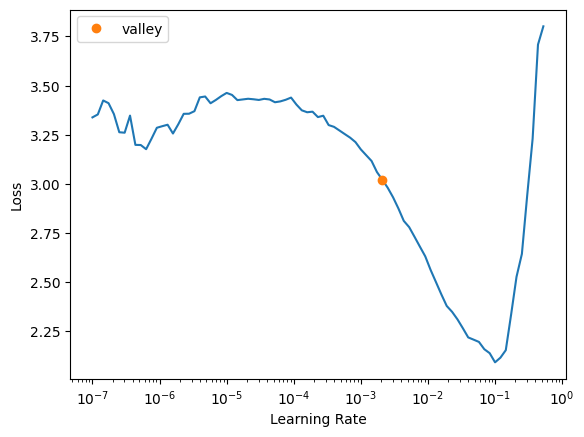

In [ ]:
from fastai.callback.tracker import EarlyStoppingCallback

# Kreiranje modela koristeći prethodno obučeni ResNet18
learn = vision_learner(dls, resnet18, metrics=accuracy, cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)])

# Pronalaženje optimalne stope učenja
learn.lr_find()

In [ ]:
# Fine-tuning modela
learn.fine_tune(epochs=5, base_lr=0.0020892962347716093)

epoch,train_loss,valid_loss,accuracy,time
0,3.247992,2.612224,0.210526,00:18


epoch,train_loss,valid_loss,accuracy,time
0,2.679432,2.317799,0.263158,00:15
1,2.232840,2.055578,0.263158,00:15
2,1.848367,1.784021,0.526316,00:15
3,1.674757,1.494301,0.526316,00:15
4,1.522721,1.314603,0.526316,00:15


Testna preciznost: 0.4736841917037964


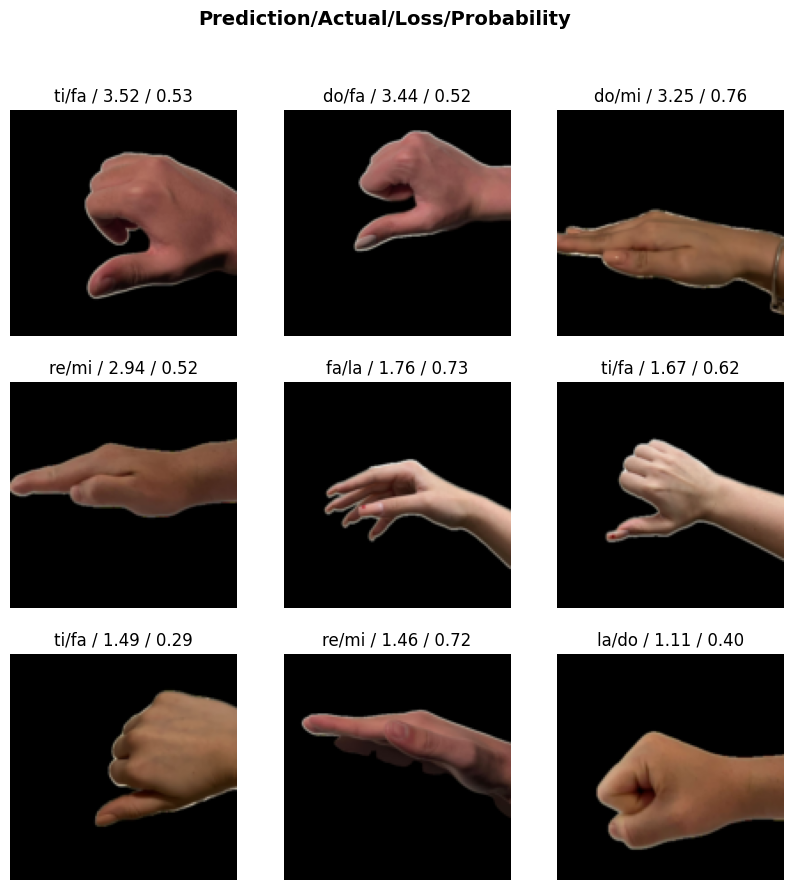

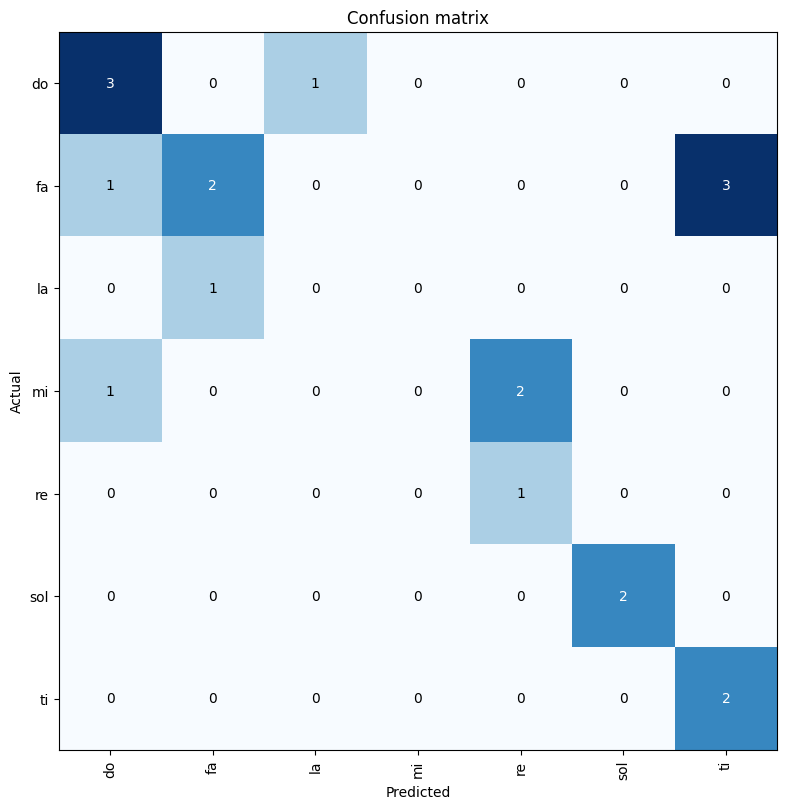

In [ ]:
# Procjena performansi modela na testnom setu
test_results = learn.validate(dl=dls.valid)
print("Testna preciznost:", 1 - test_results[1])  # error_rate

# Procjena performansi modela na pojedinačnim slikama
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(10,10))  # Prikazivanje najvećih gubitaka
interp.plot_confusion_matrix(figsize=(8,8))  # Prikazivanje matrice zabune

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Učitavanje slike i predikcija koristeći FastAI model
image_path = '/content/drive/MyDrive/test/REtest.png'
img = PILImage.create(image_path)

pred_fastai, pred_idx_fastai, probs_fastai = learn.predict(img)
print(f'Prepoznati ton (FastAI model): {pred_fastai}; Verovatnoća: {probs_fastai[pred_idx_fastai]:.2f}')


Prepoznati ton (FastAI model): re; Verovatnoća: 0.97


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = self._get_image_paths_and_labels()

    def _get_image_paths_and_labels(self):
        img_labels = []
        for root, dirs, files in os.walk(self.img_dir):
            for file in files:
                if file.endswith('.png') and 'models' not in root and '.ipynb_checkpoints' not in root:
                    label = root.split('/')[-1]  # Pretpostavlja se da je ime foldera labela
                    img_labels.append((os.path.join(root, file), label))
        return img_labels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
dataset_path = '/content/drive/MyDrive/dataset/'
dataset = CustomImageDataset(img_dir=dataset_path, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 7)  # Pretpostavimo 7 klasa

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
model = MyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mapiranje tekstualnih labela u numeričke vrednosti
label_to_index = {
    'do': 0, 're': 1, 'mi': 2, 'fa': 3, 'sol': 4, 'la': 5, 'ti': 6
}

# Dodajte transformaciju labela u vaš DataLoader loop
for epoch in range(10):  # Broj epoha
    for images, labels in loader:
        labels = torch.tensor([label_to_index[label] for label in labels])  # Pretvaranje labela u tenzore
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 8.133796691894531
Epoch 2, Loss: 1.9449318647384644
Epoch 3, Loss: 1.883286714553833
Epoch 4, Loss: 1.7935056686401367
Epoch 5, Loss: 1.4949098825454712
Epoch 6, Loss: 1.23714017868042
Epoch 7, Loss: 0.7834770083427429
Epoch 8, Loss: 0.6846957802772522
Epoch 9, Loss: 0.4966161847114563
Epoch 10, Loss: 0.38215675950050354


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Putanja do slike koju želite da testirate
image_path = '/content/drive/MyDrive/test/REtest.png'

# Transformacije koje treba primeniti na sliku
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Ista veličina kao za trening set
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Iste normalizacione vrednosti
])

# Učitavanje i transformacija slike
image = Image.open(image_path).convert('RGB')
image = transform(image)
image = image.unsqueeze(0)  # Dodajemo dodatnu dimenziju za batch (model očekuje batch slika)


In [ ]:
# Postavite model u eval mode
model.eval()

with torch.no_grad():  # Isključivanje izračunavanja gradijenta za predikciju
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)  # Dobijamo indeks najvećeg izlaza

# Mapiranje indeksa nazad u labele
index_to_label = {v: k for k, v in label_to_index.items()}
predicted_label = index_to_label[predicted.item()]

print(f'Predikcija modela: {predicted_label}')


Predikcija modela: re


In [25]:
!pip install colab-xterm
%load_ext colabxterm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 1.6 MB/s eta 0:00:00


In [26]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>